# The Vanishing/Exploding Gradients Problems
This problem occurs when information is lost during backpropagation, i.e. gradients dwindle to nothing or explode as the model diverges. This makes it very difficult to train low layers, as their weights are not being updated properly.

This can generally be solved using a better activation function or initialization (or combination thereof).

## Nonsaturating activation functions
Leaky ReLU implementation - create a leaky ReLU layer just after the layer you want to apply it to

In [1]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.Sequential([
    keras.layers.Dense(10, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(alpha=0.2)
])

SELU activation implementation

In [2]:
layer = keras.layers.Dense(10, activation="selu",
                           kernel_initializer="lecun_normal")

## Batch Normalization
Adds an operation in teh model just before or after the activation function of each hidden layer: zero-center and normalize each input, then scale and shift the result using two new parameter vectors (one for scaling and one for shifting). Lets the model learn the optimal scale and mean of each layer's inputs.

Batch normization has become ubiquitous.

### Implementing batch normalization with keras
This model adds a batch normalization layer before each hidden layer. That's it!

In [3]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [4]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_2 (Dense)              (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

let's try it on mnist

In [5]:
mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()
X_train_full.shape

(60000, 28, 28)

In [6]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [7]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [8]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
dense_5 (Dense)              (None, 200)               157000    
_________________________________________________________________
batch_normalization_4 (Batch (None, 200)               800       
_________________________________________________________________
dense_6 (Dense)              (None, 100)               20100     
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)               400       
_________________________________________________________________
dense_7 (Dense)              (None, 50)               

In [9]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [10]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4269 - accuracy: 0.8758 - val_loss: 0.1960 - val_accuracy: 0.9428
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2061 - accuracy: 0.9387 - val_loss: 0.1459 - val_accuracy: 0.9544
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.1556 - accuracy: 0.9539 - val_loss: 0.1276 - val_accuracy: 0.9600
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.1296 - accuracy: 0.9610 - val_loss: 0.1134 - val_accuracy: 0.9662
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.1116 - accuracy: 0.9656 - val_loss: 0.1073 - val_accuracy: 0.9664
Epoch 6/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0943 - accuracy: 0.9714 - val_loss: 0.1047 - val_accuracy: 0.9690
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0839 - accuracy: 0.9745 - val_loss: 0.0997 - val_accuracy:

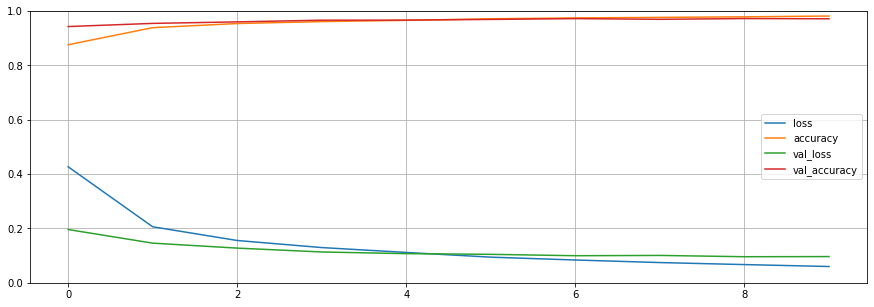

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(15, 5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

the results here are similar to what we saw in chapter 10 without batch norm, but we got to them faster! this is what we expected. if early stopping were implemented here, we should have seen a net drop in wall time.

## Gradient Clipping
Mitigate exploding gradients by limiting gradients during backpropagation so that they don't exceed a threshold. Most often used in recurrent NNs, since batch normalization is tricky with RNNs.

In [12]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="mse", optimizer=optimizer)

can also use ```clipnorm``` instead of ```clipvalue``` to ensure that clipping does not change the direction of the gradient vector.

# Reusing Pretrained Layers
## Transfer learning with Keras
Example trains model A on a subset of mnist fashion (all except sandals and shirts). Uses model A to start model B.

In [13]:
import numpy as np

def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [14]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [15]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [16]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1394/1394 [==============================] - 6s 4ms/step - loss: 0.6960 - accuracy: 0.7886 - val_loss: 0.3815 - val_accuracy: 0.9011
Epoch 2/20
1394/1394 [==============================] - 5s 4ms/step - loss: 0.3493 - accuracy: 0.9004 - val_loss: 0.2907 - val_accuracy: 0.9188
Epoch 3/20
1394/1394 [==============================] - 5s 4ms/step - loss: 0.2910 - accuracy: 0.9152 - val_loss: 0.2543 - val_accuracy: 0.9294
Epoch 4/20
1394/1394 [==============================] - 6s 4ms/step - loss: 0.2616 - accuracy: 0.9242 - val_loss: 0.2331 - val_accuracy: 0.9355
Epoch 5/20
1394/1394 [==============================] - 5s 4ms/step - loss: 0.2423 - accuracy: 0.9293 - val_loss: 0.2195 - val_accuracy: 0.9387
Epoch 6/20
1394/1394 [==============================] - 6s 4ms/step - loss: 0.2283 - accuracy: 0.9333 - val_loss: 0.2083 - val_accuracy: 0.9410
Epoch 7/20
1394/1394 [==============================] - 7s 5ms/step - loss: 0.2168 - accuracy: 0.9371 - val_loss: 0.2000 - val_accuracy:

In [17]:
model_A.save("my_model_A.h5")

In [18]:
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid")) # looking for binary classification (shirt vs sandal)

note that models A and B now share some layers! training model B will impact model A. we need to clone model A to retain it's original weights. (we also have model A saved, so that version will certainly still remain the same too)

In [19]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

when we begin to train model B, the new layer we added will possibly ruin the good layers from model A! since it's weights were randomly initialized, the gradients updated there will be large and could be detrimental lower in the network. let's freeze the lower layers to prevent this.

In [20]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

In [21]:
model_B_on_A.compile(loss="binary_crossentropy", optimizer="sgd",
                     metrics=["accuracy"])

In [22]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 36ms/step - loss: 1.1619 - accuracy: 0.2500 - val_loss: 0.8981 - val_accuracy: 0.4374
Epoch 2/4
7/7 [==============================] - 0s 13ms/step - loss: 0.8353 - accuracy: 0.4750 - val_loss: 0.7179 - val_accuracy: 0.6107
Epoch 3/4
7/7 [==============================] - 0s 16ms/step - loss: 0.6744 - accuracy: 0.6400 - val_loss: 0.6138 - val_accuracy: 0.6770
Epoch 4/4
7/7 [==============================] - 0s 14ms/step - loss: 0.5794 - accuracy: 0.6800 - val_loss: 0.5250 - val_accuracy: 0.7401


now allow all layers to be trained and run for more epochs!

In [23]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

In [24]:
optimizer = keras.optimizers.SGD(lr=1e-4)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

In [25]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/16
7/7 [==============================] - 0s 52ms/step - loss: 0.5211 - accuracy: 0.7150 - val_loss: 0.5209 - val_accuracy: 0.7444
Epoch 2/16
7/7 [==============================] - 0s 18ms/step - loss: 0.5161 - accuracy: 0.7150 - val_loss: 0.5168 - val_accuracy: 0.7497
Epoch 3/16
7/7 [==============================] - 0s 17ms/step - loss: 0.5113 - accuracy: 0.7150 - val_loss: 0.5125 - val_accuracy: 0.7508
Epoch 4/16
7/7 [==============================] - 0s 18ms/step - loss: 0.5067 - accuracy: 0.7250 - val_loss: 0.5088 - val_accuracy: 0.7572
Epoch 5/16
7/7 [==============================] - 0s 14ms/step - loss: 0.5020 - accuracy: 0.7350 - val_loss: 0.5048 - val_accuracy: 0.7594
Epoch 6/16
7/7 [==============================] - 0s 18ms/step - loss: 0.4974 - accuracy: 0.7550 - val_loss: 0.5013 - val_accuracy: 0.7594
Epoch 7/16
7/7 [==============================] - 0s 17ms/step - loss: 0.4931 - accuracy: 0.7650 - val_loss: 0.4974 - val_accuracy: 0.7636
Epoch 8/16
7/7 [===========

In [26]:
model_B_on_A.evaluate(X_test_B, y_test_B)

58/58 [==============================] - 0s 4ms/step - loss: 17.3405 - accuracy: 0.3562


[17.340518951416016, 0.3562162220478058]

didn't do well at all! if I used the same random seeds as the solutions, I would have gotten a noticeable improvement. the lesson here is that transfer learning isn't always feasible for the network at hand! the solutions note that small dense networks tend to not fare so well with transfer learning since their layers are more specific; compared to a deep CNN, the lower layers in the model above simply aren't as generalizeable or conducive to transfer learning!

# Faster Optimizers
## Momentum Optimization
Use gradient for acceleration, not velocity. Imagine a very shallow gradient: SGD will slowly move down that, but momentum would cause the "ball" to "roll faster and faster" down the slope. Can oscilate around optimum becuase of this. Needs a friction term.

In [27]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

## Nesterov Accelerated Gradient
Instead of taking the gradient at the current location, it takes it one step ahead. This works because it takes the gradient value closer to the optimum (i.e. if your gradient is pointed in the right direction, one tep further will be closer to the optimum). Tends to oscillate less. Tends to train faster.

In [28]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

Actually, figure 11-6 is pretty crazy. I'd have thought that typical momentum optimization does what Nesterov _actually_ does. I.e. typical momentum will take the gradient at a point, move according to the pre-existing momentum vector it already had, and then apply that previous gradient at it's next step... Nesterov, by this figure, is far more intuitive: it applies the _instantaneous gradient_ at that location on the step that moves the point from that location itself. Look at the diagram to understand, pg 354.

Why would "normal" momentum optimization ever be preferred?

## AdaGrad
Adjusts direction to more appropriately point to global optimum. Not useful for DNN in practice because the learning rate gets scaled down so much that the optimal solution is actually never reached.

## RMSProp
Similar to AdaGrad, but it only accumulates gradients from recent iterations by adding an exponential decay term.

In [29]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

## Adam and Nadam
Somewhat of a combo between momentum and RMSProp. Like momentum, it keeps track of an exponentially decaying average of past gradients; like RMSProp, it keeps track of an exponentially decaying average of past squared gradients.

Nadam is adam with Nesterov trick.

In [30]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

## Learning Rate Scheduling
Non-constant learning rates.

In [31]:
# power scheduling
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

In [33]:
# exponential scheduling and piecewise scheduling
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

# or, to not hard code the values:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [34]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
# history = model.fit(X_train_scaled, y_train, [...], callbacks=[lr_scheduler])

```LearningRateScheduler``` will update the learning rate at the beginning of each epoch.

can also implement this where the previous learning rate is used to determine the next learning rate.

In [35]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

be warned that epoch-dependent rates can get messed up if a model is saved, restored and set to have training resume as the epoch is reset to 0 whenever .fit() is called. Can set fit()'s initial epoch, though.

In [36]:
# piecewise constant scheduling
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [37]:
# performance scheduling
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

In [38]:
# update learning rate using schedules available in keras and then pass the lr to any optimizer
s = 20 * len(X_train) // 32 # number of seps in 20 epochs (if batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)

# Avoid Overfitting Through Regularization
## l1 and l2 regularization

In [39]:
layer = keras.layers.Dense(100, activation="relu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

can use ```.l1``` too, of course. can also use ```keras.regularizers.l1_l2``` if you want to use both.

use ```partial``` to create a wrapper for this reused callable on layers.

In [40]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

In [42]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax",
                     kernel_initializer="glorot_uniform")
])

## Dropout
At every training step, every neuron has a probability of being left out for that step. This, in essence, makes the neurons generalize better - they work better together, aren't reliant on specific neurons to pass information, and it often leads to a better model. Example given was of a company where some people wouldn't show up to work some days - to make it work, _every employee_ would need to be able to pick up the slack (and therefore have a more generalized ability to contribute).

In [43]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])

Make sure to avoid overfitting! Check training loss without dropout too. Can also increase dropout rate.

## Monte Carlo Dropout
Make predictions with dropout active and get the spread of results! This can be useful if you're building a risk-sensitive system. See example below, how a strong confidence without MC dropout becomes much less certain. Overall, MC dropout boosts dropout models and provides better uncertainty estimates.

In [45]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [46]:
# using alpha dropout (different from above)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6654 - accuracy: 0.7583 - val_loss: 0.5957 - val_accuracy: 0.8382
Epoch 2/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5548 - accuracy: 0.7969 - val_loss: 0.5728 - val_accuracy: 0.8450
Epoch 3/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5272 - accuracy: 0.8077 - val_loss: 0.5167 - val_accuracy: 0.8482
Epoch 4/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5082 - accuracy: 0.8115 - val_loss: 0.5173 - val_accuracy: 0.8446
Epoch 5/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4915 - accuracy: 0.8201 - val_loss: 0.4668 - val_accuracy: 0.8592
Epoch 6/20
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4838 - accuracy: 0.8204 - val_loss: 0.4758 - val_accuracy: 0.8594
Epoch 7/20
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4739 - accuracy: 0.8247 - val_loss: 0.4527 - val_accur

In [57]:
# make 100 predictions
y_probas = np.stack([model(X_test_scaled, training=True)
                    for sample in range(100)])
y_proba = y_probas.mean(axis=0)

In [58]:
# prediction with dropout off
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

model is very sure that it's class 9! but when we look at our MC results, not so much!

In [59]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.  , 0.97]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.96]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.37, 0.  , 0.58]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.98]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.05, 0.  , 0.94]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.15, 0.  , 0.09, 0.  , 0.76]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.98]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.98]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.41, 0.  , 0.58]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.02, 0.  , 0.97]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.17, 0.  , 0.83]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.02, 0.  , 0.97]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  , 0.03, 0.  , 0

average over the first dimension to get the MC dropout prediction. not quite 100% anymore!

In [60]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.11, 0.  , 0.85]],
      dtype=float32)

In [61]:
# also look at standard deviation of probability estimates
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.14, 0.  , 0.17]],
      dtype=float32)

In [62]:
# if model contains other layers that behave in a special way
# during training (like batch norm layers), replace Dropout layers
# with MCDropout class
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

## Max-Norm Regularization
For each neuron, constrains weights of the incoming connections such that the l2 norm of the weight vector is less than a max-norm hyperparameter r.

In [63]:
keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal",
                   kernel_constraint=keras.constraints.max_norm(1.))

# Exercises
## 8. Training a DNN on CIFAR10 image dataset
### a.

In [85]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

In [86]:
X_train_full.shape

(50000, 32, 32, 3)

In [87]:
y_train_full.shape

(50000, 1)

In [88]:
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0

In [89]:
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [90]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[32, 32, 3]),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dense(10, activation="softmax")
])

In [91]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_41 (Dense)             (None, 100)               307300    
_________________________________________________________________
dense_42 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_43 (Dense)             (None, 10)                1010      
Total params: 318,410
Trainable params: 318,410
Non-trainable params: 0
_________________________________________________________________


In [92]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [93]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.8914 - accuracy: 0.3217 - val_loss: 1.9013 - val_accuracy: 0.2904
Epoch 2/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.7206 - accuracy: 0.3868 - val_loss: 1.6834 - val_accuracy: 0.4056
Epoch 3/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.6433 - accuracy: 0.4163 - val_loss: 1.6825 - val_accuracy: 0.3784
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.5962 - accuracy: 0.4346 - val_loss: 2.0803 - val_accuracy: 0.2890
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.5566 - accuracy: 0.4488 - val_loss: 1.6330 - val_accuracy: 0.4200
Epoch 6/10
1407/1407 [==============================] - 9s 6ms/step - loss: 1.5248 - accuracy: 0.4588 - val_loss: 1.6769 - val_accuracy: 0.4094
Epoch 7/10
1407/1407 [==============================] - 9s 6ms/step - loss: 1.4973 - accuracy: 0.4710 - val_loss: 1.5855 - val_accuracy:

didn't use 20 hidden layers of 100 neurons each - that would have taken forever on my computer!

### b.

In [100]:
model_b = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[32, 32, 3]),
    keras.layers.Dense(500, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dense(250, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dense(125, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dense(10, activation="softmax")
])

In [101]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model_b.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

In [102]:
history = model_b.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid),
                     callbacks=[early_stopping_cb])

Epoch 1/10
1407/1407 [==============================] - 28s 20ms/step - loss: 1.9357 - accuracy: 0.3140 - val_loss: 1.8499 - val_accuracy: 0.3310
Epoch 2/10
1407/1407 [==============================] - 25s 18ms/step - loss: 1.7062 - accuracy: 0.3813 - val_loss: 1.7102 - val_accuracy: 0.3736
Epoch 3/10
1407/1407 [==============================] - 25s 18ms/step - loss: 1.6235 - accuracy: 0.4146 - val_loss: 1.6180 - val_accuracy: 0.4198
Epoch 4/10
1407/1407 [==============================] - 26s 18ms/step - loss: 1.5642 - accuracy: 0.4405 - val_loss: 1.6247 - val_accuracy: 0.4184
Epoch 5/10
1407/1407 [==============================] - 26s 18ms/step - loss: 1.5206 - accuracy: 0.4525 - val_loss: 1.4982 - val_accuracy: 0.4636
Epoch 6/10
1407/1407 [==============================] - 27s 19ms/step - loss: 1.4844 - accuracy: 0.4683 - val_loss: 1.4923 - val_accuracy: 0.4702
Epoch 7/10
1407/1407 [==============================] - 27s 19ms/step - loss: 1.4478 - accuracy: 0.4806 - val_loss: 1.4723 -

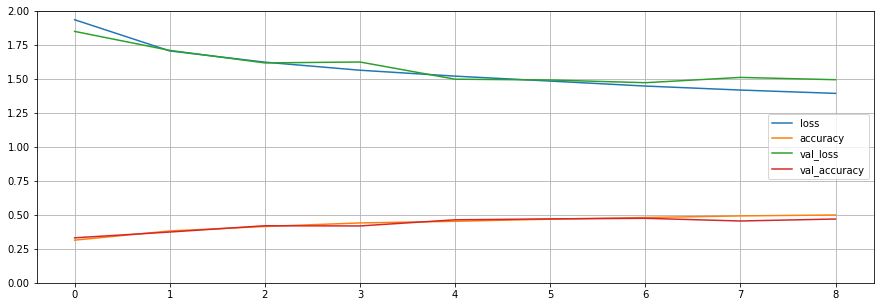

In [105]:
pd.DataFrame(history.history).plot(figsize=(15, 5))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

### c.

In [106]:
model_c = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[32, 32, 3]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(500, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(250, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(125, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [107]:
model_c.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [108]:
history_c = model_c.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid),
                     callbacks=[early_stopping_cb])

Epoch 1/10
1407/1407 [==============================] - 43s 31ms/step - loss: 1.7199 - accuracy: 0.3828 - val_loss: 1.5400 - val_accuracy: 0.4464
Epoch 2/10
1407/1407 [==============================] - 44s 32ms/step - loss: 1.4878 - accuracy: 0.4710 - val_loss: 1.4057 - val_accuracy: 0.4998
Epoch 3/10
1407/1407 [==============================] - 47s 33ms/step - loss: 1.3869 - accuracy: 0.5046 - val_loss: 1.3584 - val_accuracy: 0.5190
Epoch 4/10
1407/1407 [==============================] - 52s 37ms/step - loss: 1.3110 - accuracy: 0.5319 - val_loss: 1.3265 - val_accuracy: 0.5314
Epoch 5/10
1407/1407 [==============================] - 49s 35ms/step - loss: 1.2430 - accuracy: 0.5576 - val_loss: 1.3019 - val_accuracy: 0.5326
Epoch 6/10
1407/1407 [==============================] - 49s 35ms/step - loss: 1.1838 - accuracy: 0.5794 - val_loss: 1.2623 - val_accuracy: 0.5566
Epoch 7/10
1407/1407 [==============================] - 52s 37ms/step - loss: 1.1317 - accuracy: 0.5986 - val_loss: 1.3104 -

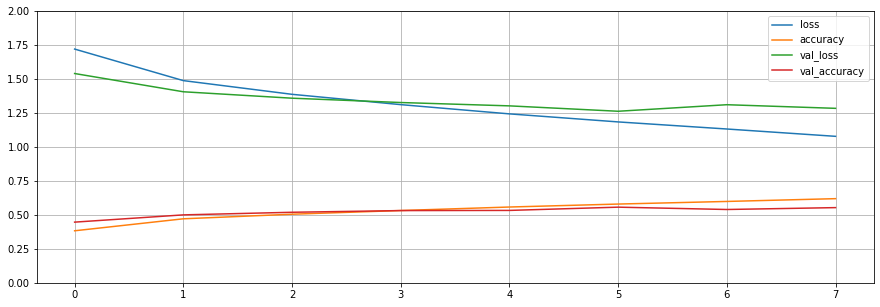

In [109]:
pd.DataFrame(history_c.history).plot(figsize=(15, 5))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

model improved at the expense of training speed! makes sense there. if this were run to more epochs, that total wall time would have likely dropped as we'd expect to converge in fewer epochs, even if the epochs take a little longer.

### d.

In [110]:
model_d = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[32, 32, 3]),
    keras.layers.Dense(500, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(250, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(125, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

In [111]:
model_d.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [112]:
history_d = model_d.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid),
                     callbacks=[early_stopping_cb])

Epoch 1/10
1407/1407 [==============================] - 29s 21ms/step - loss: 2.1901 - accuracy: 0.2723 - val_loss: 1.8615 - val_accuracy: 0.3238
Epoch 2/10
1407/1407 [==============================] - 32s 23ms/step - loss: 1.7811 - accuracy: 0.3496 - val_loss: 1.7931 - val_accuracy: 0.3460
Epoch 3/10
1407/1407 [==============================] - 25s 18ms/step - loss: 1.7040 - accuracy: 0.3820 - val_loss: 1.6064 - val_accuracy: 0.4128
Epoch 4/10
1407/1407 [==============================] - 35s 25ms/step - loss: 1.6355 - accuracy: 0.4074 - val_loss: 1.5948 - val_accuracy: 0.4192
Epoch 5/10
1407/1407 [==============================] - 33s 23ms/step - loss: 1.5855 - accuracy: 0.4265 - val_loss: 1.7160 - val_accuracy: 0.3794
Epoch 6/10
1407/1407 [==============================] - 31s 22ms/step - loss: 1.5484 - accuracy: 0.4388 - val_loss: 1.5618 - val_accuracy: 0.4400
Epoch 7/10
1407/1407 [==============================] - 30s 21ms/step - loss: 1.5199 - accuracy: 0.4526 - val_loss: 1.5363 -

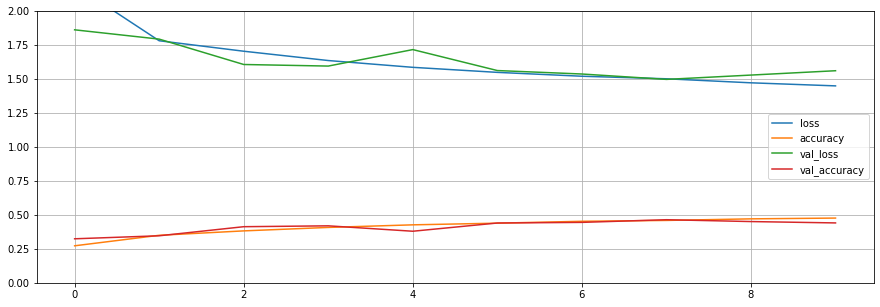

In [118]:
pd.DataFrame(history_d.history).plot(figsize=(15, 5))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

### e.

In [113]:
model_e = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[32, 32, 3]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(500, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(250, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(125, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])

In [114]:
# switch over to Nadam (was Adam) for hopefully faster convergence (although I'm not running too many epochs)
optimizer = keras.optimizers.Nadam(lr=5e-5)
model_e.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [116]:
history_e = model_e.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid),
                     callbacks=[early_stopping_cb])

Epoch 1/10
1407/1407 [==============================] - 67s 48ms/step - loss: 2.4398 - accuracy: 0.1475 - val_loss: 2.2664 - val_accuracy: 0.2044
Epoch 2/10
1407/1407 [==============================] - 77s 55ms/step - loss: 2.1593 - accuracy: 0.2023 - val_loss: 2.1310 - val_accuracy: 0.2568
Epoch 3/10
1407/1407 [==============================] - 74s 53ms/step - loss: 2.0753 - accuracy: 0.2349 - val_loss: 2.1670 - val_accuracy: 0.2564
Epoch 4/10
1407/1407 [==============================] - 72s 51ms/step - loss: 2.0341 - accuracy: 0.2529 - val_loss: 2.1099 - val_accuracy: 0.2842
Epoch 5/10
1407/1407 [==============================] - 72s 51ms/step - loss: 2.0040 - accuracy: 0.2678 - val_loss: 2.1088 - val_accuracy: 0.3072
Epoch 6/10
1407/1407 [==============================] - 71s 51ms/step - loss: 1.9867 - accuracy: 0.2763 - val_loss: 2.0212 - val_accuracy: 0.3344
Epoch 7/10
1407/1407 [==============================] - 74s 52ms/step - loss: 1.9659 - accuracy: 0.2883 - val_loss: 2.1949 -

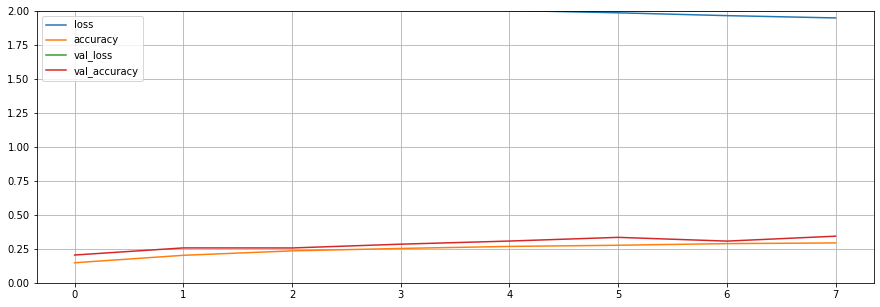

In [119]:
pd.DataFrame(history_e.history).plot(figsize=(15, 5))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

yikes!